## 中核集团也有自己的光伏发电公司

## 将分类预测结果的输出编程Cp*0.03,能够减小预测值错误

## 参赛选手最优MAE0.133，意味着白天平均每点错误13%

分类模型的任务是将比较有把握的点预测为负类
回归模型的任务是将无异常时间内的MAE降低
分类模型和回归模型都需要排除异常数据，让异常数据对模型的影响保留在官方的评价方法里

# 0.从外部传入参数

In [1]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('Number',type=int,help='输入电站序号')
parser.add_argument('Cp',type=int,help='输入电站额定功率')
args = parser.parse_args()
num=args.Number
cp=args.Cp
print('正在处理数据集{}，装机功率为{}'.format(num,cp))

usage: ipykernel_launcher.py [-h] Number Cp
ipykernel_launcher.py: error: argument Number: invalid int value: 'C:\\Users\\Home\\AppData\\Roaming\\jupyter\\runtime\\kernel-b374a57e-e504-407a-b296-e95a833594c8.json'


SystemExit: 2

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 1.文件读取

In [2]:
import os
import sys
import warnings
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
import pandas as pd
file_path="J:/人工智能学习/数据集/【更新】国能日新竞赛数据/国能日新竞赛数据/"

In [4]:
train_data=pd.read_csv(file_path+'train/train_{}.csv'.format(num),parse_dates=['时间'])
test_data=pd.read_csv(file_path+'test/test_{}.csv'.format(num),parse_dates=['时间'])
weather_data=pd.read_csv(file_path+'气象数据/电站{}_气象.csv'.format(num),parse_dates=['时间'],encoding='gbk')

In [5]:
if num==7:
    train_data=train_data[(train_data["时间"] < "2018/03/01 00:00") |(train_data["时间"] > "2018/04/04 23:45")]
    train_data.reset_index(drop=True,inplace=True)
if num == 9:
    train_data=train_data[(train_data["时间"] < "2016/01/01 9:00") | (train_data["时间"] > "2017/03/21 23:45")]
    train_data.reset_index(drop=True,inplace=True)

In [6]:
data=pd.concat([train_data,test_data],ignore_index=True)
weather_data.drop_duplicates(['时间'],inplace=True,keep='first')
data=data.merge(weather_data[['时间','直辐射','总辐射']],left_on=['时间'],right_on=['时间'])

# 2.数据探索

## 2.1 获取测试集的时间范围

In [7]:
print('测试集%s的时间范围:' % num)
start=test_data['时间'][0]
end=test_data.iloc[-1]['时间']
print(start,end)
print(80*'-')

测试集1的时间范围:
2019-01-01 00:00:00 2019-05-28 17:30:00
--------------------------------------------------------------------------------


## 2.2 获取出现数据缺失的时间段

In [8]:
import numpy as np
def find_null_time(name,file_num):
    print(name+'数据集'+str(file_num))
    temp_data=pd.read_csv(file_path+'{}/{}_{}.csv'.format(name,name,file_num),parse_dates=['时间'] )
    null_temp_0=temp_data['时间']
    null_temp_1=null_temp_0.shift(-1)
    null_temp=pd.concat([null_temp_0,null_temp_1],axis=1)
    null_temp.dropna(inplace=True)
    new_column_name=['原时间','移位时间']
    null_temp.columns=new_column_name
    null_temp.head()
    null_temp['delta_time']=null_temp['移位时间']-null_temp['原时间']
    null_temp['time_trans']=(null_temp['delta_time']/(np.timedelta64(1,'m'))).astype(int)
    print(null_temp[null_temp['time_trans']!=15])
    print(80*'-')

In [9]:
for name in ['train','test']:
    find_null_time(name,num)

train数据集1
                      原时间                移位时间       delta_time  time_trans
4408  2017-02-15 22:15:00 2017-02-16 08:15:00  0 days 10:00:00         600
4919  2017-02-21 15:45:00 2017-02-21 16:15:00  0 days 00:30:00          30
5869  2017-03-03 13:30:00 2017-03-03 14:00:00  0 days 00:30:00          30
6147  2017-03-06 11:15:00 2017-03-26 13:15:00 20 days 02:00:00       28920
11891 2017-05-25 09:00:00 2017-05-25 14:30:00  0 days 05:30:00         330
12074 2017-05-27 12:00:00 2017-05-27 12:30:00  0 days 00:30:00          30
12265 2017-05-29 12:00:00 2017-05-29 12:30:00  0 days 00:30:00          30
12747 2017-06-03 12:45:00 2017-06-03 18:00:00  0 days 05:15:00         315
12843 2017-06-04 17:45:00 2017-06-04 18:15:00  0 days 00:30:00          30
13864 2017-06-15 09:15:00 2017-06-15 10:15:00  0 days 01:00:00          60
14886 2017-06-26 01:30:00 2017-06-26 09:30:00  0 days 08:00:00         480
15742 2017-07-05 07:15:00 2017-07-05 08:15:00  0 days 01:00:00          60
18638 2017-08-0

## 2.3 对电站实际功率为零的特殊样本进行探索

In [10]:
df_error_time=train_data[train_data['实际功率']==0]
df_error_time['当日时间']=df_error_time['时间'].dt.time
df_error_time['小时']=df_error_time['时间'].apply(lambda x:x.hour)
print('实际功率为零的样本数量:',train_data.shape[0],df_error_time.shape[0],round((df_error_time.shape[0])/(train_data.shape[0]),4))
df_error_time.to_csv(file_path+'error_time/error_{}.csv'.format(num),encoding='gbk')

实际功率为零的样本数量: 65760 2544 0.0387


## 2.4 查看每日实际功率最大值时间

In [11]:
from pandas import Series
train_data['年月日']=train_data['时间'].dt.date
train_data['当日时间']=train_data['时间'].dt.time
the_max_time=train_data.groupby('年月日').apply(lambda x:x.loc[Series.argmax(x['实际功率'])]['当日时间'])
the_max_time.to_csv(file_path+'the_max_time.csv',encoding='gbk')

通过对最大值功率在0点分析表明，当天数据量小时应该删除当天数据
2017年9月整体发电功率都偏小，怀疑是否有故障的原因

## 2.5 查看实际功率/实际辐照度的数值

In [12]:
temp=train_data[(train_data['实际功率']>0)&(train_data['实际辐照度']>0)]

In [13]:
temp['实际比例']=temp['实际功率']/temp['实际辐照度']

In [14]:
temp.to_csv(file_path+'实际比例_{}.csv'.format(num),encoding='gbk')

## 2.4 通过一些极值来查看规律

In [15]:
train_data['辐照度'].argmax()
train_data['湿度'].argmin()
train_data['实际辐照度'].argmax()

39052

## 2.5 通过日平均值来找寻规律

In [16]:
train_data['年月日']=train_data['时间'].dt.date
import seaborn as sns
import matplotlib.pyplot as plt
def day_info_plot(info_word,start,end,drop=True):
    start_time=pd.to_datetime(start,format='%Y%m%d')
    end_time=pd.to_datetime(end,format='%Y%m%d')
    sel_data=train_data[(train_data['时间']>=start_time) & (train_data['时间']<=end_time)]
    if drop:
        sel_data=sel_data[sel_data['实际功率']>0.6]
    else: 
        pass
    day_info=sel_data.groupby('年月日')[info_word].agg({'平均值':'mean'})
    day_info.reset_index(inplace=True)
    plt.figure(figsize=(30,10))
    sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif')
    axes = plt.gca()
    axes.set_xlim([start_time,end_time])
    sns.scatterplot(x='年月日',y='平均值',data=day_info,legend='full')
    plt.savefig(file_path+"my_plot/train_{}_{}.png".format(num,info_word))

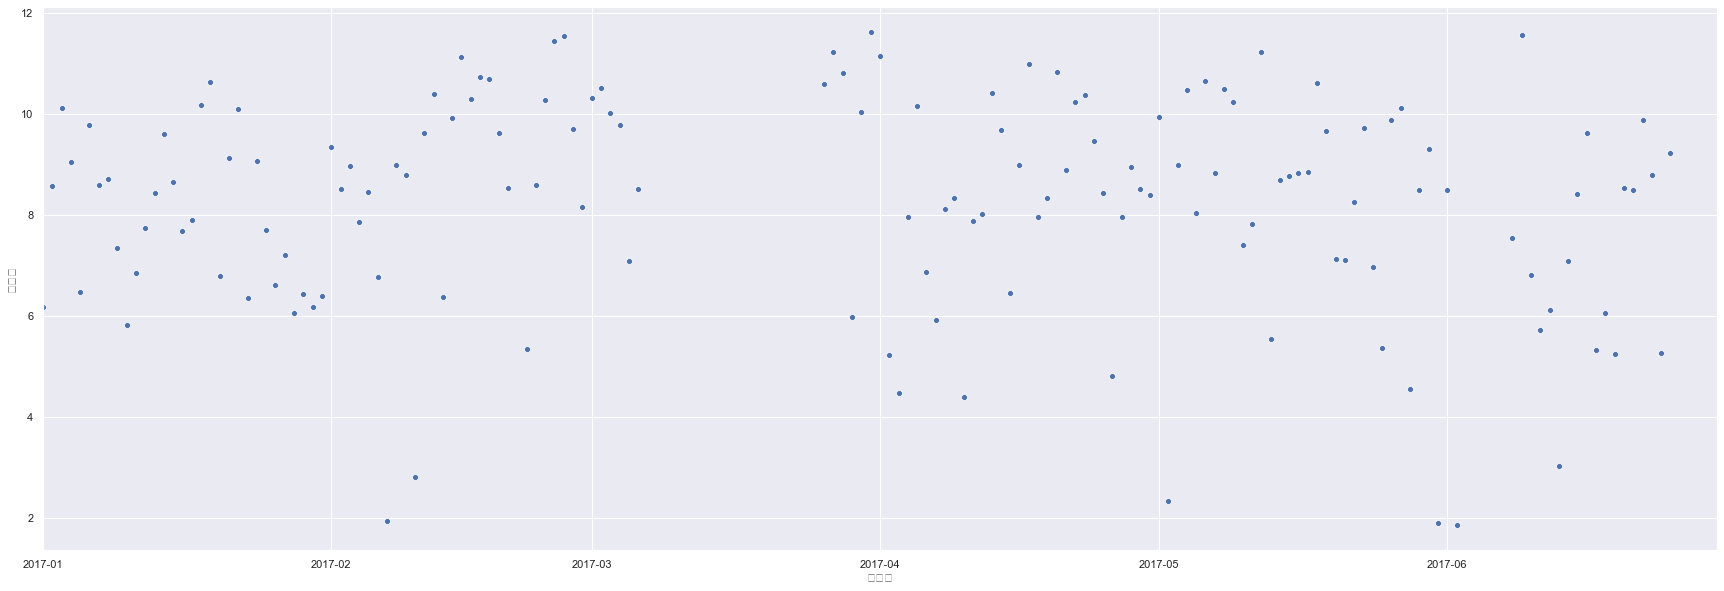

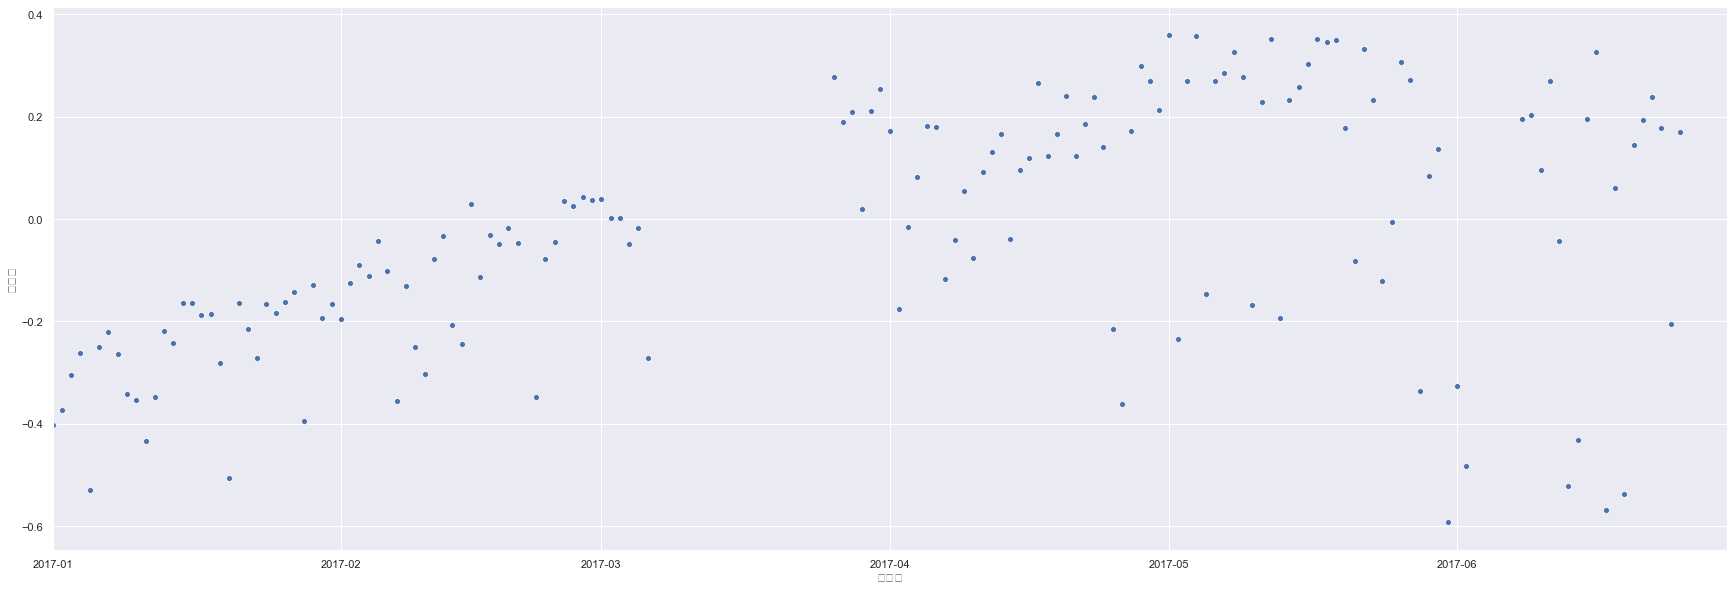

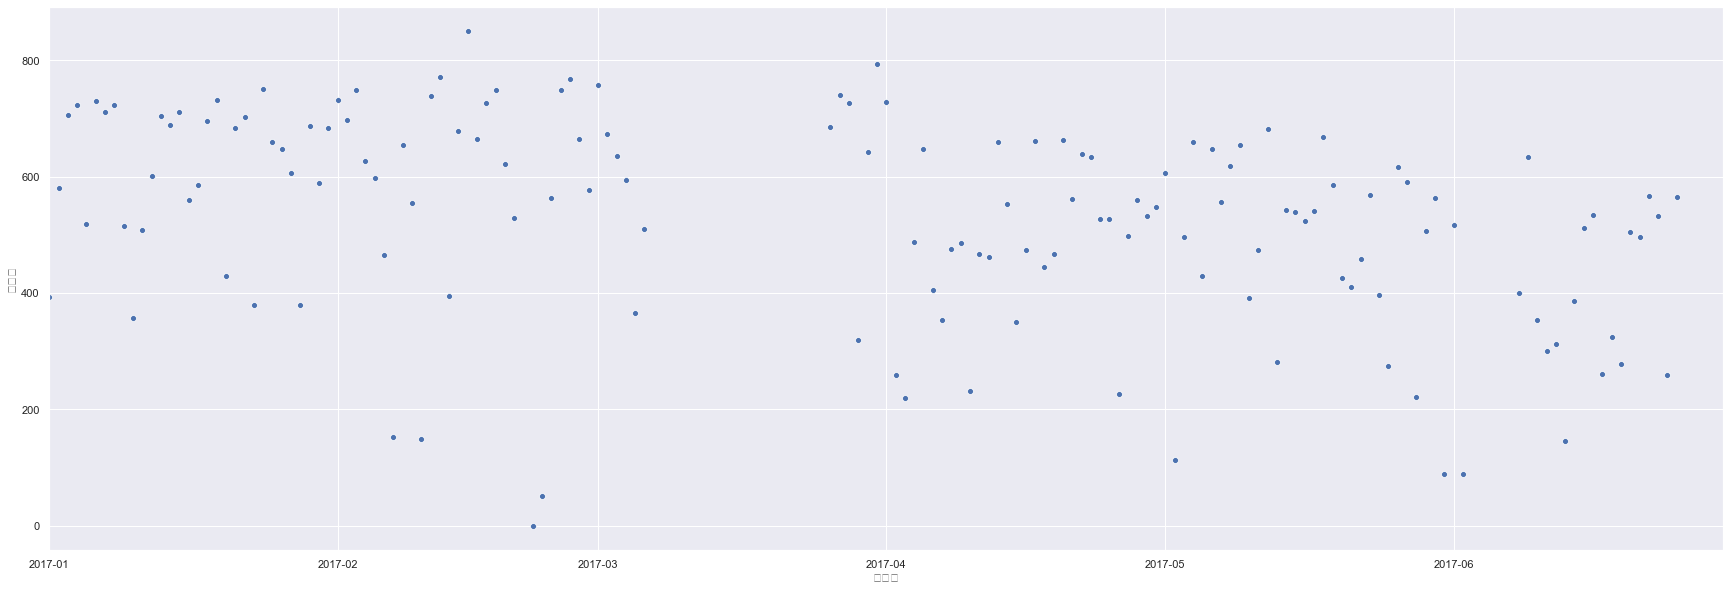

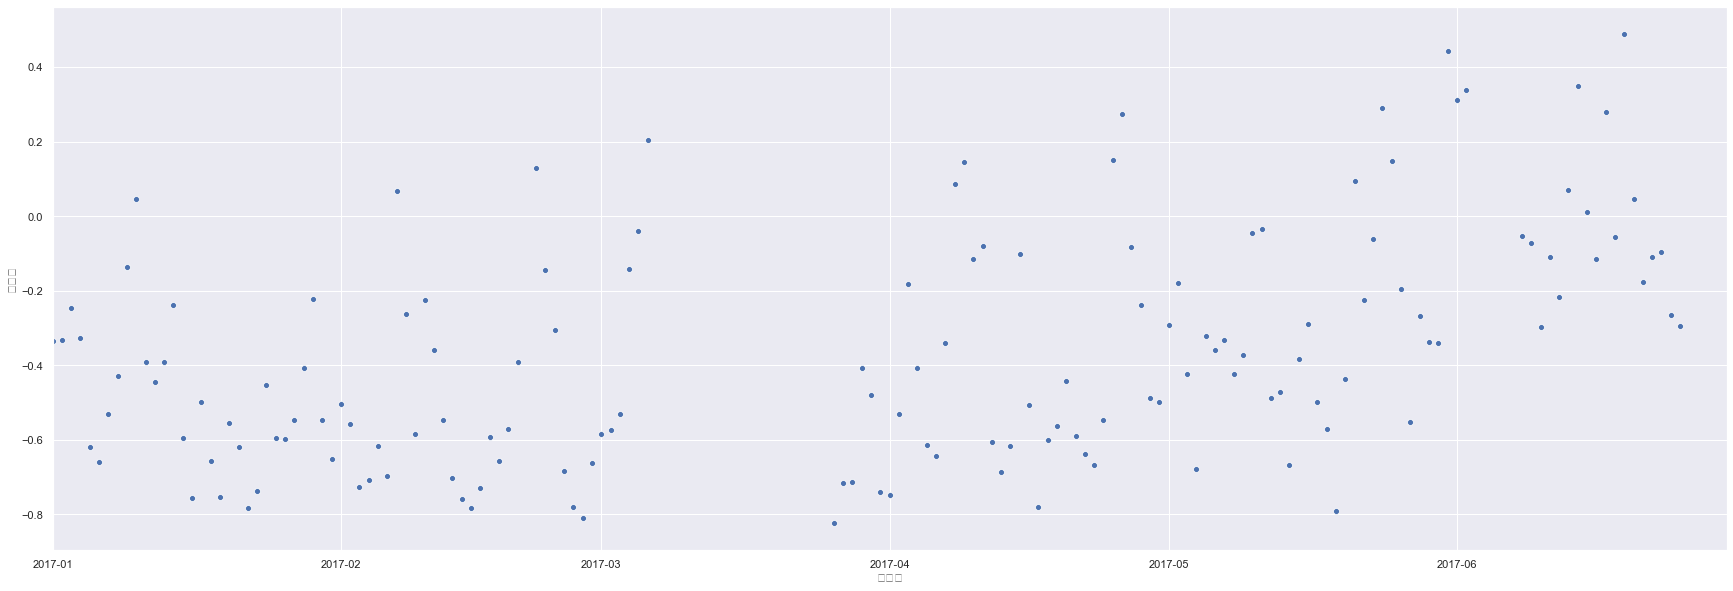

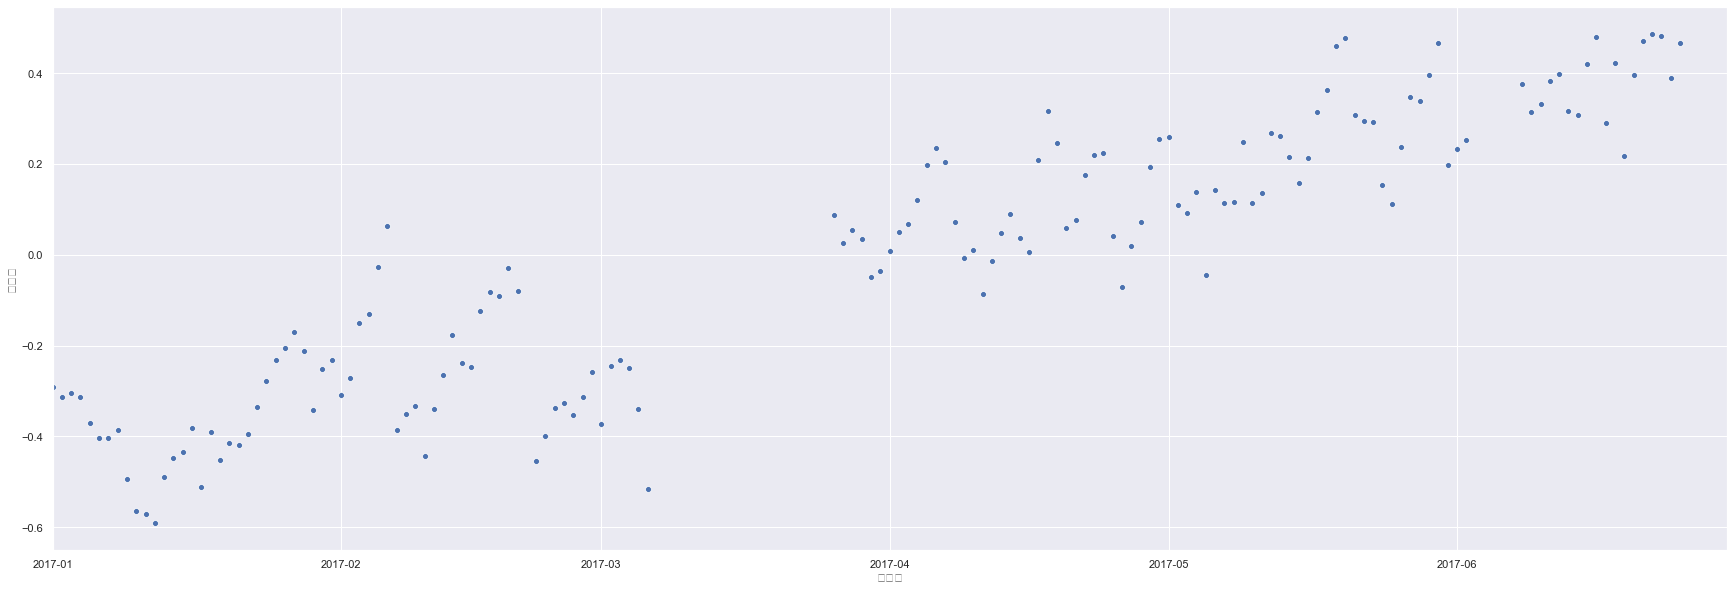

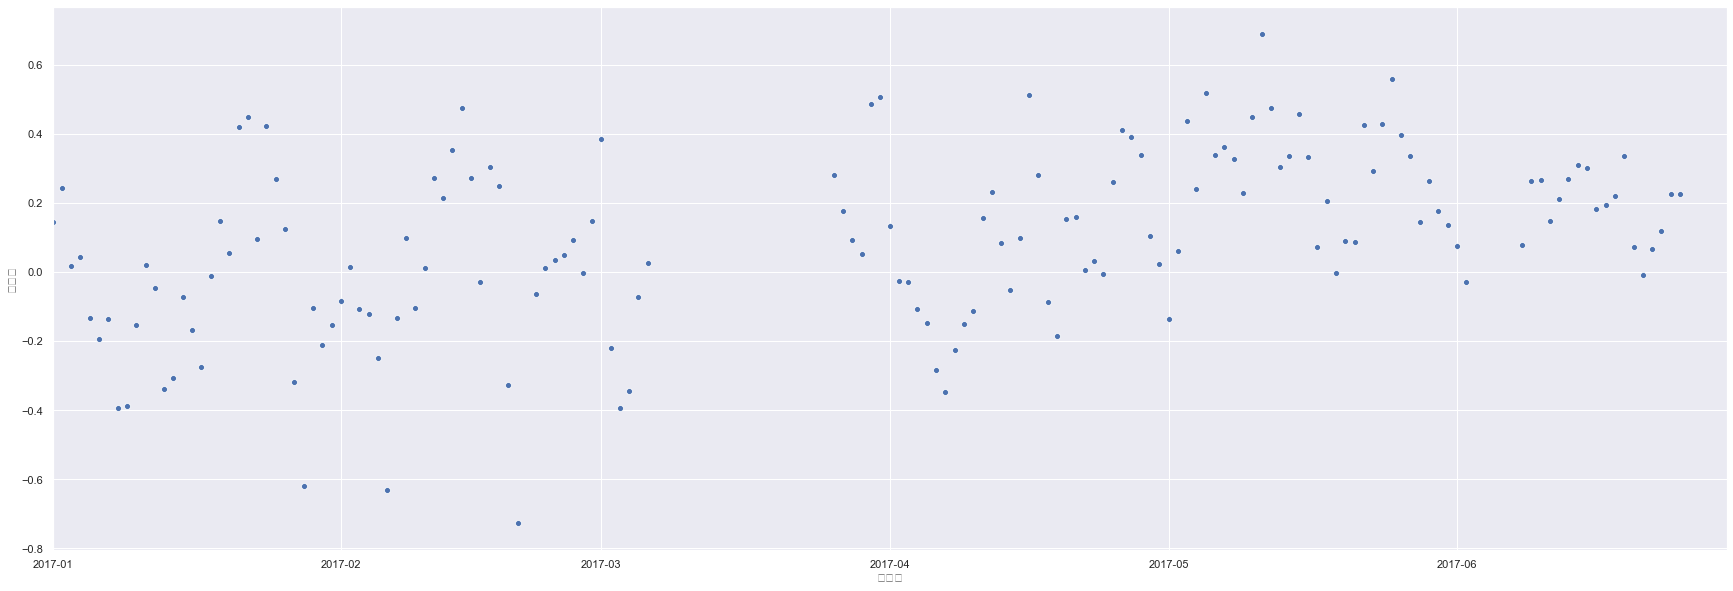

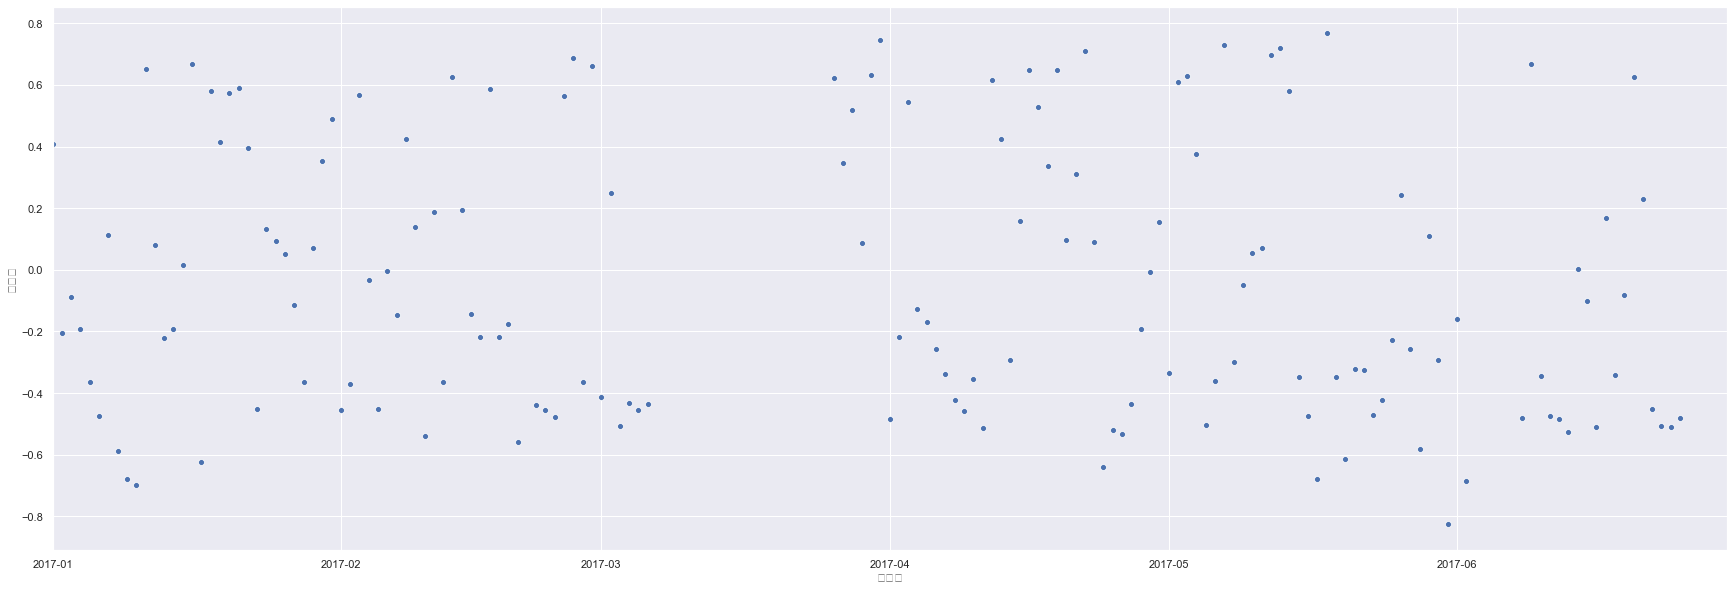

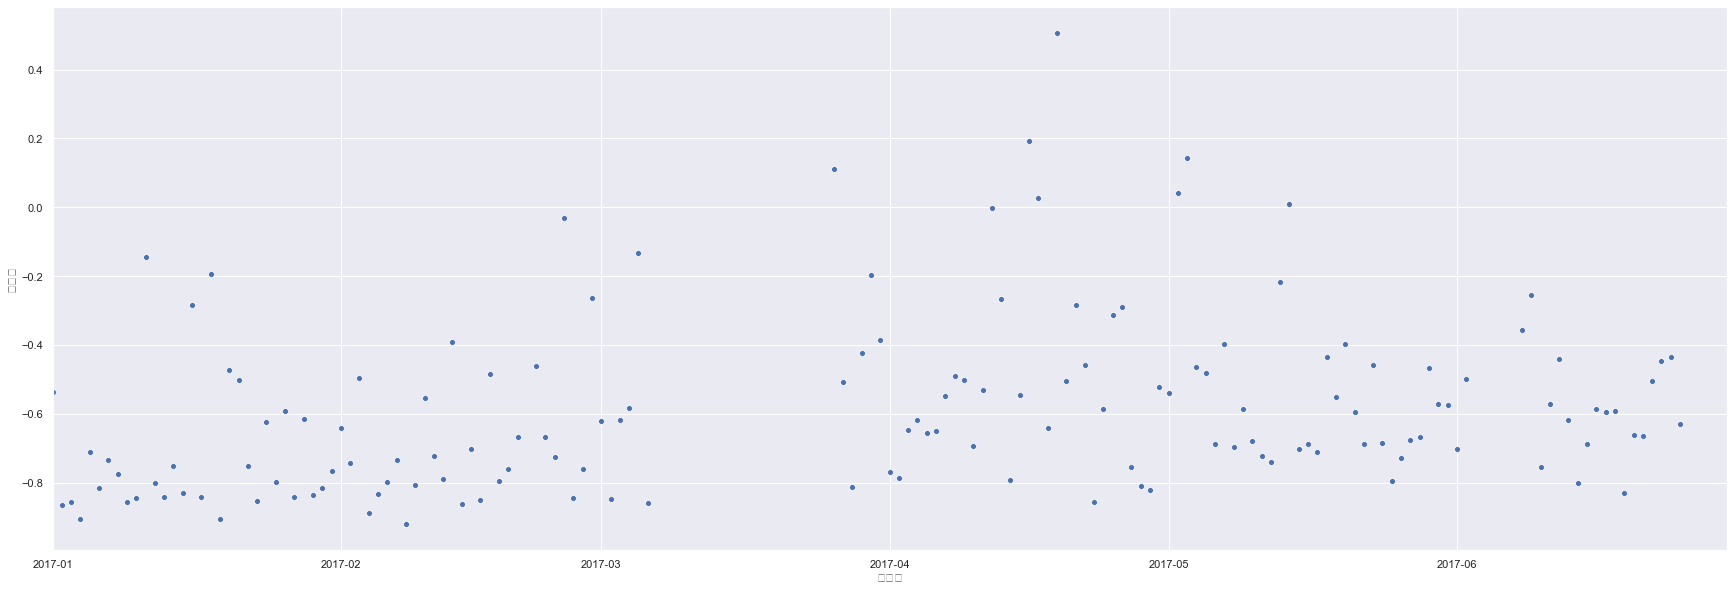

In [17]:
for word in ['实际功率','辐照度','实际辐照度','湿度','温度','压强','风向','风速']:
    day_info_plot(word,20170101,20170630)

## 2.6 统计每个月早晨/晚上计入功率时间

In [18]:
import datetime as dt
temp_data_0=train_data[(train_data['实际功率']>0.6)&(train_data['当日时间']<dt.time(11,59,59))]
the_time=temp_data_0.groupby('年月日').apply(lambda x:x.loc[Series.argmin(x['实际功率'])]['当日时间'])
df_the_time=the_time.reset_index()
df_the_time.to_csv(file_path+'早晨计入时间_{}.csv'.format(num),encoding='gbk')

In [19]:
temp_data_1=train_data[(train_data['实际功率']>0.6)&(train_data['当日时间']>dt.time(11,59,59))]
the_time=temp_data_1.groupby('年月日').apply(lambda x:x.loc[Series.argmin(x['实际功率'])]['当日时间'])
df_the_time=the_time.reset_index()
df_the_time.to_csv(file_path+'晚上计入时间_{}.csv'.format(num),encoding='gbk')

## 2.7 散辐射值唯一，不加入特征

In [20]:
weather_data['散辐射'].unique()

array([-1], dtype=int64)